In [ ]:
from torch import nn
import torch
import gym
from collections import deque
import numpy as np
import random
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Network(nn.Module):
    def __init__(self, env):
        super().__init__()
        in_features = int(np.prod(env.observation_space.shape))
        self.net = nn.Sequential(nn.Linear(in_features,64),
                                 nn.Tanh(),
                                 nn.Linear(64, env.action_space.n))

    def forward(self, x):
        return self.net(x)

    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action

In [ ]:
Gamma = 0.99
Batch_size = 32
Buffer_size = 50000
Min_replay_size = 1000
Epsilon_start = 1.0
Epsilon_end = 0.02
Epsilon_decay = 10000
target_update_freq = 1000
learning_rate = 0.00025


In [ ]:
env = gym.make("CartPole-v0")
output_pd = pd.DataFrame()

replay_buffer = deque(maxlen=Buffer_size)
rew_buffer = deque([0.0], maxlen=100)

episode_reward = 0.0

online_net = Network(env)
target_net = Network(env)

target_net.load_state_dict(online_net.state_dict())
optimizer = torch.optim.Adam(online_net.parameters(), lr=learning_rate)

obs = env.reset()
for _ in range(Min_replay_size):
    action = env.action_space.sample()

    new_obs, rew, done, info = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs

    if done:
        obs = env.reset()

obs = env.reset()

for step in itertools.count():
    epsilon = np.interp(step, [0, Epsilon_decay], [Epsilon_start, Epsilon_end])
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        action = online_net.act(obs)
    new_obs, rew, done, _ = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs
    episode_reward += rew

    if done:
        obs = env.reset()

        rew_buffer.append(episode_reward)
        episode_reward = 0.0
    '''
    if len(rew_buffer) >= 100:
        if np.mean(rew_buffer) >= 195:
            while True:
                action = online_net.act(obs)

                obs, _, done, _ = env.step(action)
                env.render()
                if done:
                    env.reset()
    '''
    transitions = random.sample(replay_buffer, Batch_size)
    obses = np.asarray([t[0] for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rews = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([t[4] for t in transitions])

    obses_t = torch.as_tensor(obses, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_obses_t  = torch.as_tensor(new_obses, dtype=torch.float32)

    target_q_values = target_net(new_obses_t)
    max_target_q_values = target_q_values.max(dim=1, keepdim = True)[0]

    targets = rews_t + Gamma * (1 - dones_t) * max_target_q_values

    q_values = online_net(obses_t)
    action_q_values = torch.gather(input=q_values, dim=1 , index=actions_t)
    loss = nn.functional.smooth_l1_loss(action_q_values, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  

    if step % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    if step % 1000 == 0:
        '''
        if step > 50000:
            print()
            print("Finally")
            print(output)
            sys.exit()
        '''            
        #print('Step ', step)
        #print("Avg rew ", np.mean(rew_buffer))
        output_pd = output_pd.append({"Reward": episode_reward, "Step": step}, ignore_index=True)

        if step == 250000:
            break


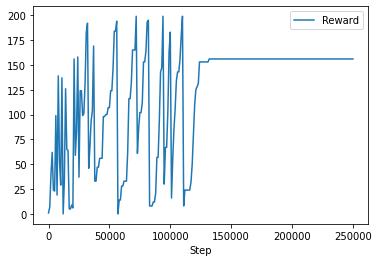

In [ ]:
output_pd.plot(x="Step", y="Reward", kind="line")